In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from gtfparse import read_gtf
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
import matplotlib.lines as mlines
from matplotlib.lines import Line2D
from scipy.stats import ttest_1samp, mannwhitneyu, wilcoxon
import bioframe
import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## DARs

In [2]:
peaks = pd.read_csv('/DATA/users/magnitov/tacl/atacseq/peaks/all_peaks.canonical.replicated.no_blacklist.merged.bed',
                   sep = '\t', header = None)
peaks.columns = ['chrom', 'start', 'end']
peaks['peak_id'] = ['_'.join([x[0], str(x[1]), str(x[2])]) for x in peaks.values]

# Read TACL domains peaks
tacl_domains = pd.read_csv('/DATA/users/magnitov/tacl/4c/TACL_domains_HMM.bed',sep = '\t', header = None)
tacl_domains.columns = ['chrom', 'start', 'end', 'teto_id']
tacl_domains_peaks = bioframe.overlap(peaks, tacl_domains, how='left').dropna()['peak_id'].values
peaks['tacl_domain'] = [1 if x in tacl_domains_peaks else 0 for x in peaks['peak_id'].values]

tacl_domains_peaks = bioframe.overlap(peaks, tacl_domains, how='left').dropna()['peak_id'].values
peaks['tacl_domain'] = [1 if x in tacl_domains_peaks else 0 for x in peaks['peak_id'].values]

peaks.head()

,chrom,start,end,peak_id,tacl_domain
0,chr1,826713,828018,chr1_826713_828018,0
1,chr1,869651,870226,chr1_869651_870226,0
2,chr1,880376,880913,chr1_880376_880913,0
3,chr1,903767,905676,chr1_903767_905676,0
4,chr1,912789,913245,chr1_912789_913245,0


#### T-MAU2 vs T-mCherry

In [3]:
dars_tmau2_tmcherry = pd.read_csv('/DATA/users/magnitov/tacl/atacseq/dars/dars_TMAU2_vs_TmCherry_DESeq2.csv', sep = '\s+', header = 0)
dars_tmau2_tmcherry['peak_id'] = dars_tmau2_tmcherry.index
dars_tmau2_tmcherry.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,peak_id
chr1_826713_828018,504.541266,-0.104986,0.152744,-0.687331,0.491874,0.996544,chr1_826713_828018
chr1_869651_870226,261.870434,-0.109906,0.213607,-0.514523,0.606886,0.996912,chr1_869651_870226
chr1_880376_880913,250.302584,-0.420172,0.204372,-2.055922,0.039790,0.760369,chr1_880376_880913
chr1_903767_905676,633.854366,0.125264,0.148593,0.843002,0.399227,0.990148,chr1_903767_905676
chr1_912789_913245,78.941297,0.541924,0.403782,1.342121,0.179557,0.948151,chr1_912789_913245


In [4]:
dars_tmau2_tmcherry = dars_tmau2_tmcherry.merge(peaks, on = 'peak_id')

columns_to_save = ['chrom', 'start', 'end', 'peak_id', 'tacl_domain', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
dars_tmau2_tmcherry = dars_tmau2_tmcherry[columns_to_save]

dars_tmau2_tmcherry.sort_values('padj').head()

,chrom,start,end,peak_id,tacl_domain,log2FoldChange,baseMean,pvalue,padj
89909,chrX,153226333,153226986,chrX_153226333_153226986,0,-1.890787,343.703688,2.025292e-22,1.753457e-17
29881,chr16,59304503,59305403,chr16_59304503_59305403,1,-2.324338,151.575886,3.917695e-17,1.695931e-12
7379,chr1,237832760,237834355,chr1_237832760_237834355,1,-1.419245,563.051193,8.968632e-17,2.588287e-12
73373,chr7,5524730,5526991,chr7_5524730_5526991,0,-0.930100,1178.767028,3.844108e-16,8.320379e-12
41196,chr2,61959790,61960307,chr2_61959790_61960307,0,-1.317241,316.746328,3.430755e-12,5.806052e-08


In [5]:
dars_tmau2_tmcherry_up = dars_tmau2_tmcherry[(dars_tmau2_tmcherry['padj'] < 0.05) & (dars_tmau2_tmcherry['log2FoldChange'] > 0.5)]
dars_tmau2_tmcherry_down = dars_tmau2_tmcherry[(dars_tmau2_tmcherry['padj'] < 0.05) & (dars_tmau2_tmcherry['log2FoldChange'] < -0.5)]
dars_tmau2_tmcherry_stable = dars_tmau2_tmcherry[~dars_tmau2_tmcherry['peak_id'].isin([x for x in dars_tmau2_tmcherry['peak_id'].values \
                                          if x in dars_tmau2_tmcherry_down['peak_id'].values or x in dars_tmau2_tmcherry_up['peak_id'].values])]

print('Up-regulated:', len(dars_tmau2_tmcherry_up))
print('Down-regulated:', len(dars_tmau2_tmcherry_down))
print('No change:', len(dars_tmau2_tmcherry_stable))

Up-regulated: 45
Down-regulated: 161
No change: 89865


#### T-MAU2+Dox vs T-MAU2

In [8]:
dars_dox_tmau2 = pd.read_csv('/DATA/users/magnitov/tacl/atacseq/dars/dars_TMAU2_Dox_vs_TMAU2_DESeq2.csv', sep = '\s+', header = 0)
dars_dox_tmau2['peak_id'] = dars_dox_tmau2.index
dars_dox_tmau2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,peak_id
chr1_826713_828018,504.541266,0.012949,0.149139,0.086822,0.930813,0.999977,chr1_826713_828018
chr1_869651_870226,261.870434,-0.163943,0.209852,-0.781231,0.434667,0.999977,chr1_869651_870226
chr1_880376_880913,250.302584,0.099368,0.200855,0.494724,0.620795,0.999977,chr1_880376_880913
chr1_903767_905676,633.854366,0.068765,0.144372,0.476307,0.633856,0.999977,chr1_903767_905676
chr1_912789_913245,78.941297,0.169095,0.383130,0.441350,0.658960,0.999977,chr1_912789_913245


In [9]:
dars_dox_tmau2 = dars_dox_tmau2.merge(peaks, on = 'peak_id')

columns_to_save = ['chrom', 'start', 'end', 'peak_id', 'tacl_domain', 'log2FoldChange', 'baseMean', 'pvalue', 'padj']
dars_dox_tmau2 = dars_dox_tmau2[columns_to_save]

dars_dox_tmau2.sort_values('padj').head()

,chrom,start,end,peak_id,tacl_domain,log2FoldChange,baseMean,pvalue,padj
31521,chr17,19457850,19458655,chr17_19457850_19458655,1,0.813873,380.257697,0.000002,0.163013
0,chr1,826713,828018,chr1_826713_828018,0,0.012949,504.541266,0.930813,0.999977
60048,chr4,113878512,113879145,chr4_113878512_113879145,0,-0.197760,164.423991,0.425567,0.999977
60047,chr4,113810453,113811078,chr4_113810453_113811078,0,-0.229580,28.260926,0.697084,0.999977
60046,chr4,113800572,113801306,chr4_113800572_113801306,0,0.424492,45.922948,0.335476,0.999977


In [10]:
dars_dox_tmau2_up = dars_dox_tmau2[(dars_dox_tmau2['padj'] < 0.05) & (dars_dox_tmau2['log2FoldChange'] > 0.5)]
dars_dox_tmau2_down = dars_dox_tmau2[(dars_dox_tmau2['padj'] < 0.05) & (dars_dox_tmau2['log2FoldChange'] < -0.5)]
dars_dox_tmau2_stable = dars_dox_tmau2[~dars_dox_tmau2['peak_id'].isin([x for x in dars_dox_tmau2['peak_id'].values \
                                          if x in dars_dox_tmau2_down['peak_id'].values or x in dars_dox_tmau2_up['peak_id'].values])]

print('Up-regulated:', len(dars_dox_tmau2_up))
print('Down-regulated:', len(dars_dox_tmau2_down))
print('No change:', len(dars_dox_tmau2_stable))

Up-regulated: 0
Down-regulated: 0
No change: 90071


## Volcano plots

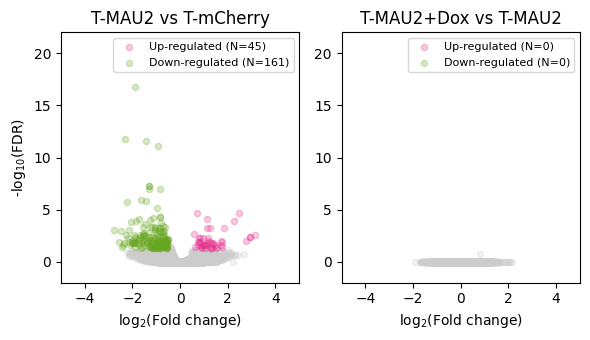

In [17]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(dars_tmau2_tmcherry_stable['log2FoldChange'], -np.log10(dars_tmau2_tmcherry_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(dars_tmau2_tmcherry_up['log2FoldChange'], -np.log10(dars_tmau2_tmcherry_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated (N=' + str(len(dars_tmau2_tmcherry_up)) + ')', alpha = 0.25, s = 20)
plt.scatter(dars_tmau2_tmcherry_down['log2FoldChange'], -np.log10(dars_tmau2_tmcherry_down['padj']), 
            color = '#66A61E', label = 'Down-regulated (N=' + str(len(dars_tmau2_tmcherry_down)) + ')', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.ylabel(r'-log$_{10}$(FDR)', fontsize = 10)
plt.xlim((-5, 5))
plt.ylim((-2, 22))
plt.yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(dars_dox_tmau2_stable['log2FoldChange'], -np.log10(dars_dox_tmau2_stable['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(dars_dox_tmau2_up['log2FoldChange'], -np.log10(dars_dox_tmau2_up['padj']), 
            color = '#E72A8A', label = 'Up-regulated (N=' + str(len(dars_dox_tmau2_up)) + ')', alpha = 0.25, s = 20)
plt.scatter(dars_dox_tmau2_down['log2FoldChange'], -np.log10(dars_dox_tmau2_down['padj']), 
            color = '#66A61E', label = 'Down-regulated (N=' + str(len(dars_dox_tmau2_down)) + ')', alpha = 0.25, s = 20)

plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.xlim((-5, 5))
plt.ylim((-2, 22))
plt.yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.savefig('/DATA/users/magnitov/tacl/figures/atacseq_volcano.pdf', bbox_inches = 'tight')
plt.show()

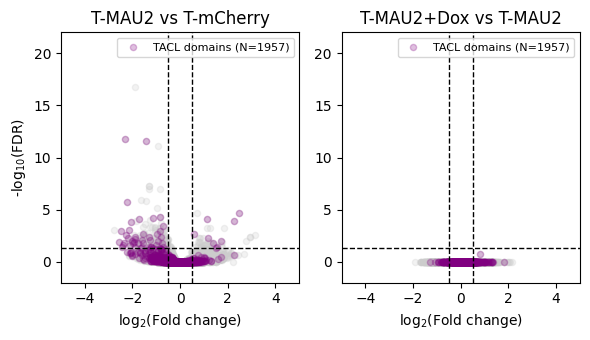

In [19]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(dars_tmau2_tmcherry['log2FoldChange'], 
            -np.log10(dars_tmau2_tmcherry['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1]['log2FoldChange'], 
            -np.log10(dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1]['padj']), 
            color = 'purple', label = 'TACL domains (N=' + str(len(dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1])) + ')', alpha = 0.25, s = 20)
plt.axvline(0.5, lw = 1, ls = '--', color = 'k')
plt.axvline(-0.5, lw = 1, ls = '--', color = 'k')
plt.axhline(-np.log10(0.05), lw = 1, ls = '--', color = 'k')
plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.ylabel(r'-log$_{10}$(FDR)', fontsize = 10)
plt.xlim((-5, 5))
plt.ylim((-2, 22))
plt.yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(dars_dox_tmau2['log2FoldChange'], 
            -np.log10(dars_dox_tmau2['padj']), 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1]['log2FoldChange'], 
            -np.log10(dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1]['padj']), 
            color = 'purple', label = 'TACL domains (N=' + str(len(dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1])) + ')', alpha = 0.25, s = 20)
plt.axvline(0.5, lw = 1, ls = '--', color = 'k')
plt.axvline(-0.5, lw = 1, ls = '--', color = 'k')
plt.axhline(-np.log10(0.05), lw = 1, ls = '--', color = 'k')
plt.xlabel('log$_2$(Fold change)', fontsize = 10)
plt.xlim((-5, 5))
plt.ylim((-2, 22))
plt.yticks([0, 5, 10, 15, 20], [0, 5, 10, 15, 20])
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.savefig('/DATA/users/magnitov/tacl/figures/atacseq_volcano_peaks_color_by_hmm.pdf', bbox_inches = 'tight')
plt.show()

## MA plots

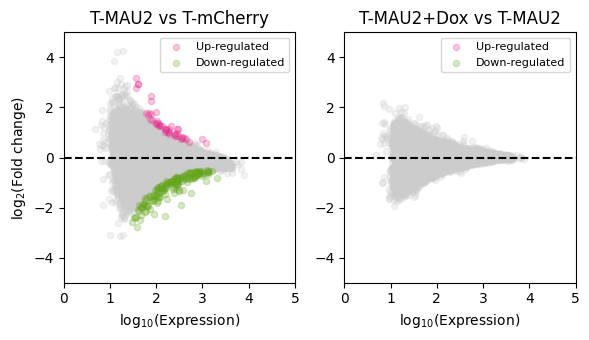

In [20]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(np.log10(dars_tmau2_tmcherry_stable['baseMean']), dars_tmau2_tmcherry_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_tmau2_tmcherry_up['baseMean']), dars_tmau2_tmcherry_up['log2FoldChange'], 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_tmau2_tmcherry_down['baseMean']), dars_tmau2_tmcherry_down['log2FoldChange'], 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylabel('log$_2$(Fold change)', fontsize = 10)
plt.ylim((-5, 5))
plt.xlim((0, 5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(np.log10(dars_dox_tmau2_stable['baseMean']), dars_dox_tmau2_stable['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_dox_tmau2_up['baseMean']), dars_dox_tmau2_up['log2FoldChange'], 
            color = '#E72A8A', label = 'Up-regulated', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_dox_tmau2_down['baseMean']), dars_dox_tmau2_down['log2FoldChange'], 
            color = '#66A61E', label = 'Down-regulated', alpha = 0.25, s = 20)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylim((-5, 5))
plt.xlim((0, 5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.savefig('/DATA/users/magnitov/tacl/figures/atacseq_ma.pdf', bbox_inches = 'tight')
plt.show()

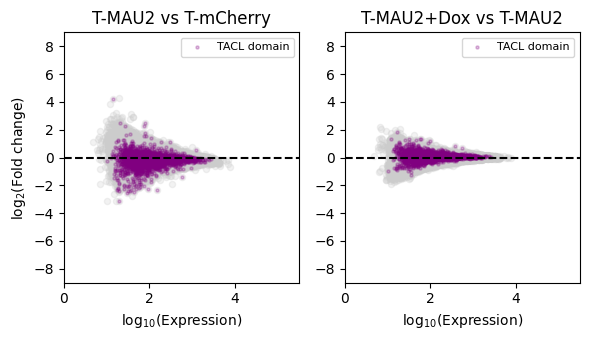

In [21]:
plt.figure(figsize = (6, 3.5))

plt.subplot(121)
plt.title('T-MAU2 vs T-mCherry', fontsize = 12)
plt.scatter(np.log10(dars_tmau2_tmcherry['baseMean']), dars_tmau2_tmcherry['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1]['baseMean']), 
            dars_tmau2_tmcherry[dars_tmau2_tmcherry['tacl_domain'] == 1]['log2FoldChange'], 
            color = 'purple', label = 'TACL domain', alpha = 0.25, s = 5)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylabel('log$_2$(Fold change)', fontsize = 10)
plt.ylim((-9, 9))
plt.xlim((0, 5.5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.subplot(122)
plt.title('T-MAU2+Dox vs T-MAU2', fontsize = 12)
plt.scatter(np.log10(dars_dox_tmau2['baseMean']), dars_dox_tmau2['log2FoldChange'], 
            color = '#CCCCCC', label = '_nolegend_', alpha = 0.25, s = 20)
plt.scatter(np.log10(dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1]['baseMean']), 
            dars_dox_tmau2[dars_dox_tmau2['tacl_domain'] == 1]['log2FoldChange'], 
            color = 'purple', label = 'TACL domain', alpha = 0.25, s = 5)
plt.axhline(0, ls = '--', color = 'k')
plt.xlabel(r'log$_{10}$(Expression)', fontsize = 10)
plt.ylim((-9, 9))
plt.xlim((0, 5.5))
plt.legend(loc = 'upper right', fontsize = 8)

plt.tight_layout()
plt.show()

### Counts inside/outside TACL domains

In [22]:
pd.DataFrame([[len(dars_tmau2_tmcherry_down[dars_tmau2_tmcherry_down['tacl_domain'] == 1]),
               len(dars_tmau2_tmcherry_up[dars_tmau2_tmcherry_up['tacl_domain'] == 1]),
               len(dars_tmau2_tmcherry_stable[dars_tmau2_tmcherry_stable['tacl_domain'] == 1])],
              [len(dars_tmau2_tmcherry_down[dars_tmau2_tmcherry_down['tacl_domain'] == 0]),
               len(dars_tmau2_tmcherry_up[dars_tmau2_tmcherry_up['tacl_domain'] == 0]),
               len(dars_tmau2_tmcherry_stable[dars_tmau2_tmcherry_stable['tacl_domain'] == 0])]],
             columns = ['Down-regulated', 'Up-regulated', 'Stable'], index = ['TACL domain', 'Other']).transpose()

,TACL domain,Other
Down-regulated,43,118
Up-regulated,9,36
Stable,1905,87960


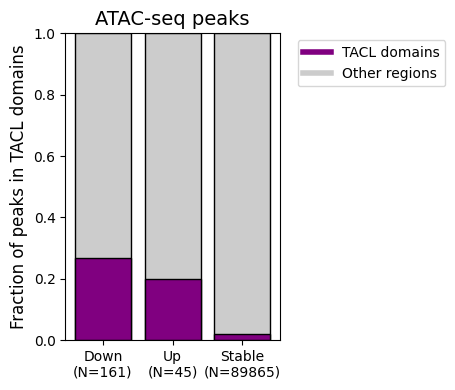

In [23]:
plt.figure(figsize = (3, 4))
plt.title('ATAC-seq peaks', fontsize = 14)
plt.bar([0, 1, 2], [1, 1, 1], color = '#CCCCCC', edgecolor = 'k', lw = 1)
plt.bar([0, 1, 2], [len(dars_tmau2_tmcherry_down[dars_tmau2_tmcherry_down['tacl_domain'] == 1])/len(dars_tmau2_tmcherry_down),
                    len(dars_tmau2_tmcherry_up[dars_tmau2_tmcherry_up['tacl_domain'] == 1])/len(dars_tmau2_tmcherry_up),
                    len(dars_tmau2_tmcherry_stable[dars_tmau2_tmcherry_stable['tacl_domain'] == 1])/len(dars_tmau2_tmcherry_stable)],
        edgecolor = 'k', lw = 1, color = 'purple')
plt.xticks([0, 1, 2], ['Down\n(N=' + str(len(dars_tmau2_tmcherry_down)) + ')', 
                       'Up\n(N=' + str(len(dars_tmau2_tmcherry_up)) + ')', 
                       'Stable\n(N=' + str(len(dars_tmau2_tmcherry_stable)) + ')'])
plt.ylabel('Fraction of peaks in TACL domains', fontsize = 12)
plt.ylim((0, 1))
plt.tight_layout()
custom_lines = [Line2D([0], [0], color='purple', lw=4),
                Line2D([0], [0], color='#CCCCCC', lw=4)]
plt.legend(custom_lines, ['TACL domains', 'Other regions'], bbox_to_anchor = (1.05, 1))
plt.savefig('/DATA/users/magnitov/tacl/figures/atacseq_peaks_overlap_tacl_domains.pdf', bbox_inches = 'tight')
plt.show()